In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
# Import libraries
import os
from pathlib import Path
from collections import Counter

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import pollock.utils as utils
import pollock.explain as explain

In [3]:
# Load training dataset
adata = anndata.read_h5ad('data/datasets/humanized_mouse_integrated_atlas.h5ad')
adata.var_names_make_unique()
adata

/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/compat/__init__.py:371: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 44269 × 13238
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'celltype', 'cell_type', 'RNA_snn_res.0.8', 'seurat_clusters', 'RNA_snn_res.0.5'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    uns: 'neighbors'
    obsm: 'X_harmony_UMAP', 'X_harmony_pca', 'X_pca', 'X_umap'
    varm: 'HARMONY_PCA', 'PCs'
    obsp: 'distances'

In [4]:
# Use only Sharma data 
#adata = adata[adata.obs['dataset'] == 'Sharma', :]
#adata

In [5]:
# Create copy of dataset for later
counts_adata = adata.copy()

In [6]:
# Pollock models take raw counts (un-normalized) expression data as input. 
# Here we add a layer to the anndata object with the raw counts so they can be stored for module training later.

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata.raw = adata

In [7]:
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

sc.pp.scale(adata, max_value=10)

/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'orig.ident' as categorical
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'dataset' as categorical
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'celltype' as categorical
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'cell_type' as categorical
/datb/pe/jussi/pollock/env/lib/python3

In [8]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

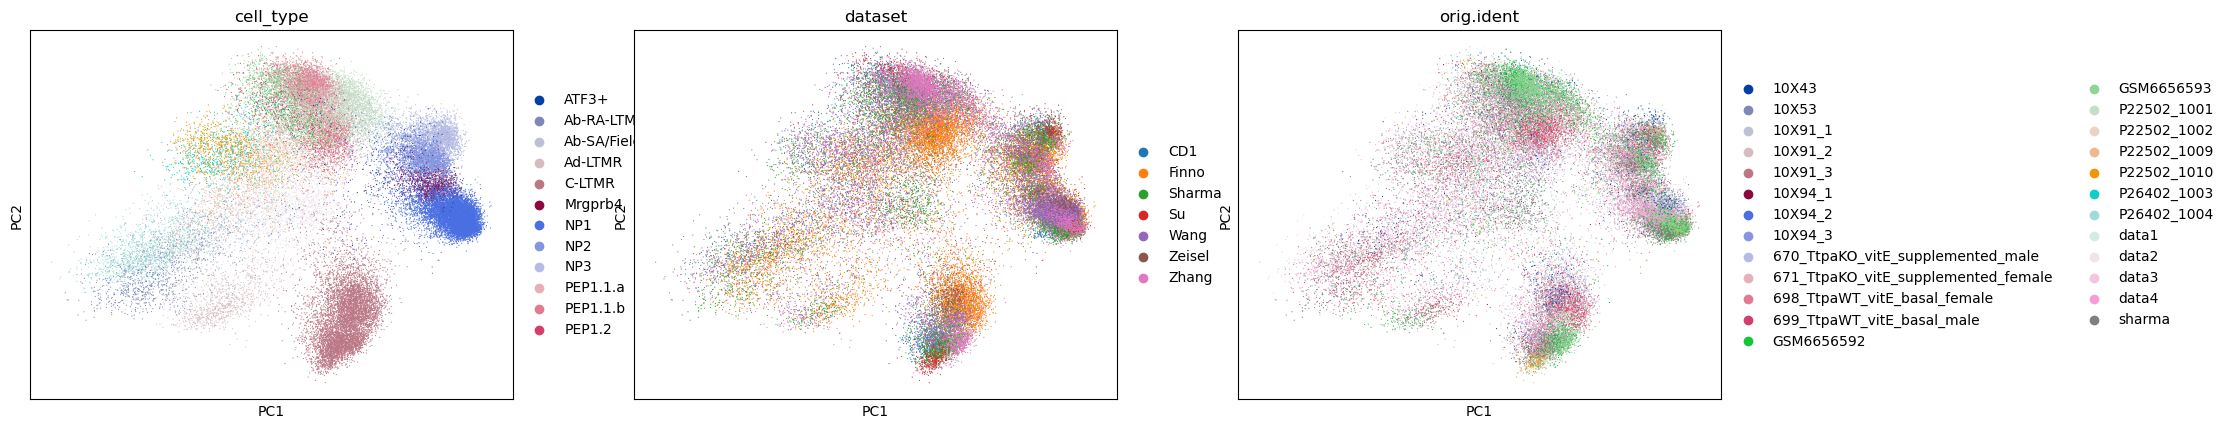

In [9]:
sc.pl.pca(adata, color=['cell_type', 'dataset', 'orig.ident'])

In [10]:
#!micromamba install -y -c conda-forge leidenalg

In [11]:
# Compute UMAP using a specific reduction as input
sc.pp.neighbors(adata, use_rep='X_harmony_pca') 
sc.tl.umap(adata)

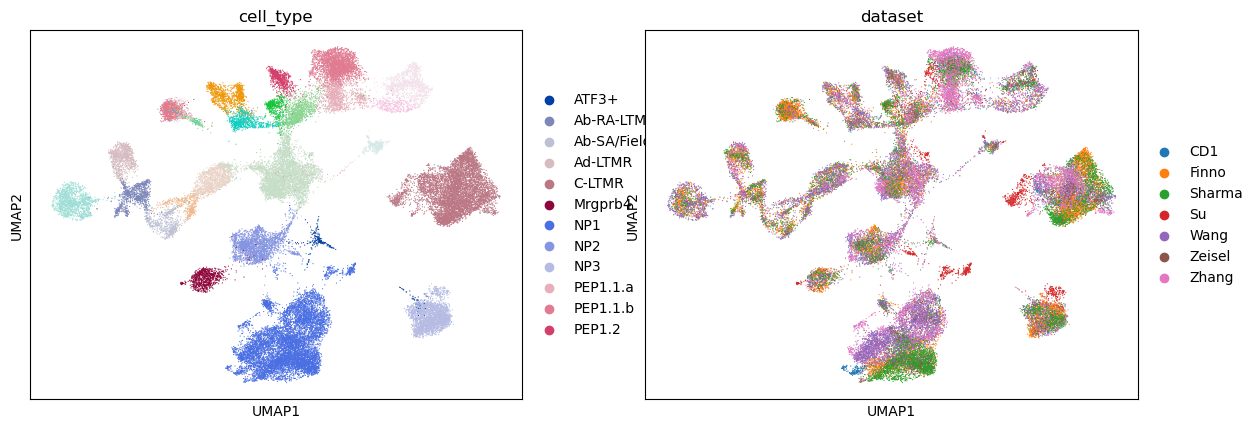

In [12]:
sc.pl.umap(adata, color=['cell_type', 'dataset'])

In [13]:
# Save the anndata object for later
adata.write_h5ad('data/humanized_mouse_atlas_FULL.h5ad')

... storing 'var.features' as categorical


## 3. train pollock module

In [14]:
# Specify a location to save the trained pollock module
module_save_filepath = 'models/mouse_atlas_humanized_full'
Path(module_save_filepath).mkdir(parents=True, exist_ok=True)

In [15]:
# Transfer cell types from the processed anndata object to the stored anndata object with raw counts.
# Pollock expects the raw counts data to be in the X attribute.
counts_adata = counts_adata[adata.obs.index]
counts_adata.obs['cell_type'] = adata.obs['cell_type'].to_list()
counts_adata.obs.head()

/tmp/ipykernel_992722/1257383715.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  counts_adata.obs['cell_type'] = adata.obs['cell_type'].to_list()


,orig.ident,nCount_RNA,nFeature_RNA,dataset,celltype,cell_type,RNA_snn_res.0.8,seurat_clusters,RNA_snn_res.0.5
10X91_1_AACACGTCAAGTTGTC-1,10X91_1,24534.0,4982,CD1,PEP1.2,PEP1.2,38,7,7
10X91_1_AACCGCGCAAATACAG-1,10X91_1,14483.0,3973,CD1,C-LTMR,C-LTMR,40,0,0
10X91_1_AACTCTTGTACACCGC-1,10X91_1,36109.0,5599,CD1,C-LTMR,C-LTMR,40,0,0
10X91_1_AACTTTCGTAGCGTGA-1,10X91_1,27680.0,5000,CD1,PEP1.4,PEP1.4,47,2,2
10X91_1_AAGACCTCACGCCAGT-1,10X91_1,29386.0,5206,CD1,PEP1.4,PEP1.4,47,2,2


In [16]:
# Take a look at our cell counts
Counter(counts_adata.obs['cell_type']).most_common()

[('NP1', 9620),
 ('C-LTMR', 7047),
 ('PEP1.4', 4369),
 ('PEP1.1.b', 3698),
 ('NP3', 2770),
 ('NP2', 2417),
 ('PEP1.1.a', 1352),
 ('Proprioceptor', 1328),
 ('PEP1.3.b', 1325),
 ('PEP2.1', 1243),
 ('TRPM8.1', 1128),
 ('PEP3.1', 1024),
 ('Ab-RA-LTMR', 1013),
 ('Ad-LTMR', 983),
 ('Mrgprb4', 880),
 ('PEP3.2', 798),
 ('PEP1.2', 712),
 ('Ab-SA/Field', 655),
 ('PEP1.3.a', 495),
 ('PEP2.2', 429),
 ('TRPM8.2', 371),
 ('Rxfp1', 349),
 ('ATF3+', 263)]

In [17]:
# lets take a look at the defaults pollock model training arguments
utils.DEFAULT_TRAIN_ARGS

{'lr': 0.0001,
 'epochs': 20,
 'batch_size': 64,
 'latent_dim': 64,
 'enc_out_dim': 128,
 'middle_dim': 512,
 'kl_scaler': 0.001,
 'clf_scaler': 1.0,
 'zinb_scaler': 0.5,
 'use_cuda': False,
 'cell_type_key': 'cell_type',
 'module_filepath': './new_module'}

Typically default training arguments will give good results, but below are descriptions of some key arguments.

Training arguments
  - latent_dim
    - size of latent embedding layer
  - enc_out_dim
    - output dimension of encoder
  - middle_dim
    - dimension of intermediate encoder and decoder layers
  - kl_scaler
    - how much to weight KL divergence loss
  - clf_scaler
    - how much to weight classification loss
  - zinb_scaler
    - how much to weight zinb reconstruction loss
  - cell_type_key
    - key in .obs where the cell type label is stored
  - use_cuda
    - whether to use gpu for model training
  - module_filepath
    - filepath to save pollock model

In [18]:
# we will use default train args
args = utils.DEFAULT_TRAIN_ARGS

# set the model save filepath
args['module_filepath'] = module_save_filepath

# if you have GPUs installed and visible on this machine you can train with gpu to significantly speed up model training
# args['use_cuda'] = True
args

{'lr': 0.0001,
 'epochs': 20,
 'batch_size': 64,
 'latent_dim': 64,
 'enc_out_dim': 128,
 'middle_dim': 512,
 'kl_scaler': 0.001,
 'clf_scaler': 1.0,
 'zinb_scaler': 0.5,
 'use_cuda': False,
 'cell_type_key': 'cell_type',
 'module_filepath': 'models/mouse_atlas_humanized_full'}

In [19]:
# Next we need to create our training and validation datasets
# Typically we recommend balancing the training dataset to ensure that each cell type is equally represented
# Here we use the built in get_splits function to create our training dataset. 
# 80% of cells for each cell type will be put in a training pool that is then drawn from to create even numbers of each cell type.

# get train ids
train_ids, remaining_ids = utils.get_splits(counts_adata, 'cell_type', n_per_cell_type=500,
                                            oversample=True, split=.8)

# get validation ids from remaining ids. here we take min(num cells remaining, 100) cells for each cell type.
val_ids, _ = utils.get_splits(counts_adata[remaining_ids], 'cell_type', n_per_cell_type=100, 
                              oversample=False, split=1.)

train, val = counts_adata[train_ids], counts_adata[val_ids]
train.shape, val.shape

((11500, 13238), (2271, 13238))

In [20]:
Counter(train.obs['cell_type']).most_common()

[('PEP1.2', 500),
 ('C-LTMR', 500),
 ('PEP1.4', 500),
 ('NP1', 500),
 ('PEP1.1.a', 500),
 ('TRPM8.1', 500),
 ('PEP1.1.b', 500),
 ('NP3', 500),
 ('Mrgprb4', 500),
 ('PEP3.1', 500),
 ('NP2', 500),
 ('PEP3.2', 500),
 ('PEP1.3.b', 500),
 ('Ad-LTMR', 500),
 ('Rxfp1', 500),
 ('TRPM8.2', 500),
 ('PEP1.3.a', 500),
 ('PEP2.1', 500),
 ('ATF3+', 500),
 ('PEP2.2', 500),
 ('Proprioceptor', 500),
 ('Ab-RA-LTMR', 500),
 ('Ab-SA/Field', 500)]

In [21]:
Counter(val.obs['cell_type']).most_common()

[('C-LTMR', 100),
 ('PEP1.4', 100),
 ('NP1', 100),
 ('TRPM8.1', 100),
 ('PEP1.1.b', 100),
 ('PEP3.1', 100),
 ('NP2', 100),
 ('NP3', 100),
 ('PEP1.1.a', 100),
 ('PEP3.2', 100),
 ('Mrgprb4', 100),
 ('TRPM8.2', 100),
 ('PEP1.3.b', 100),
 ('PEP1.3.a', 100),
 ('Rxfp1', 100),
 ('PEP1.2', 100),
 ('PEP2.1', 100),
 ('Ad-LTMR', 100),
 ('Proprioceptor', 100),
 ('Ab-RA-LTMR', 100),
 ('PEP2.2', 100),
 ('Ab-SA/Field', 100),
 ('ATF3+', 71)]

In [22]:
utils.train_and_save_model(train, val, args)

2025-09-09 07:10:53,325 beginning training
2025-09-09 07:10:53,326 creating dataloaders
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:285: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/datb/pe/jussi/p

note: if it appears that the model is either overfitting (validation loss hits minimum and then starts rising) or underfitting (validation loss is still dropping and has yet to flatten out) it may be benificial to adjust the args['epochs'] parameter to train the model for a shorter or longer period of time.

In [23]:
def save_training_metrics_df(model_directory, output_path=None):
    """
    Simple function to extract and save training metrics as a pandas DataFrame.
    
    Parameters:
    -----------
    model_directory : str
        Path to the directory containing the saved model
    output_path : str, optional
        Path to save the CSV file. If None, saves as 'training_metrics.csv'
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the training metrics
    """
    import json
    import pandas as pd
    import os
    
    # Load the model summary
    summary_path = os.path.join(model_directory, 'summary.json')
    with open(summary_path, 'r') as f:
        summary = json.load(f)
    
    # Extract history and convert to DataFrame
    metrics_df = pd.DataFrame(summary['history'])
    
    # Make epoch 1-indexed for readability
    metrics_df['epoch'] = metrics_df['epoch'] + 1
    
    # Save to CSV
    if output_path is None:
        output_path = 'training_metrics.csv'
    
    metrics_df.to_csv(output_path, index=False)
    print(f"✅ Training metrics saved to {output_path}")
    print(f"📊 Shape: {metrics_df.shape}")
    print(f"📋 Columns: {list(metrics_df.columns)}")
    
    return metrics_df

# Usage:
# metrics_df = save_training_metrics_df(module_save_filepath)

# Or specify a custom output path:
# metrics_df = save_training_metrics_df(module_save_filepath, "my_model_metrics.csv")

✅ Training metrics saved to training_metrics.csv
📊 Shape: (20, 43)
📋 Columns: ['epoch', 'time', 'train loss', 'val loss', 'val reconstruction loss', 'val_kl_loss', 'val classification loss', 'train_total_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_classification_loss', 'val_total_loss', 'val_reconstruction_loss', 'val_classification_loss', 'train_accuracy', 'val_accuracy', 'train_macro_f1', 'val_macro_f1', 'train_weighted_f1', 'val_weighted_f1', 'val_f1_ATF3+', 'val_f1_Ab-RA-LTMR', 'val_f1_Ab-SA/Field', 'val_f1_Ad-LTMR', 'val_f1_C-LTMR', 'val_f1_Mrgprb4', 'val_f1_NP1', 'val_f1_NP2', 'val_f1_NP3', 'val_f1_PEP1.1.a', 'val_f1_PEP1.1.b', 'val_f1_PEP1.2', 'val_f1_PEP1.3.a', 'val_f1_PEP1.3.b', 'val_f1_PEP1.4', 'val_f1_PEP2.1', 'val_f1_PEP2.2', 'val_f1_PEP3.1', 'val_f1_PEP3.2', 'val_f1_Proprioceptor', 'val_f1_Rxfp1', 'val_f1_TRPM8.1', 'val_f1_TRPM8.2']


In [24]:
# Save metrics
metrics_df = save_training_metrics_df(module_save_filepath, output_path="full_atlas_training_metrics.csv")

✅ Training metrics saved to full_atlas_training_metrics.csv
📊 Shape: (20, 43)
📋 Columns: ['epoch', 'time', 'train loss', 'val loss', 'val reconstruction loss', 'val_kl_loss', 'val classification loss', 'train_total_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_classification_loss', 'val_total_loss', 'val_reconstruction_loss', 'val_classification_loss', 'train_accuracy', 'val_accuracy', 'train_macro_f1', 'val_macro_f1', 'train_weighted_f1', 'val_weighted_f1', 'val_f1_ATF3+', 'val_f1_Ab-RA-LTMR', 'val_f1_Ab-SA/Field', 'val_f1_Ad-LTMR', 'val_f1_C-LTMR', 'val_f1_Mrgprb4', 'val_f1_NP1', 'val_f1_NP2', 'val_f1_NP3', 'val_f1_PEP1.1.a', 'val_f1_PEP1.1.b', 'val_f1_PEP1.2', 'val_f1_PEP1.3.a', 'val_f1_PEP1.3.b', 'val_f1_PEP1.4', 'val_f1_PEP2.1', 'val_f1_PEP2.2', 'val_f1_PEP3.1', 'val_f1_PEP3.2', 'val_f1_Proprioceptor', 'val_f1_Rxfp1', 'val_f1_TRPM8.1', 'val_f1_TRPM8.2']


,epoch,time,train loss,val loss,val reconstruction loss,val_kl_loss,val classification loss,train_total_loss,train_reconstruction_loss,train_kl_loss,...,val_f1_PEP1.3.b,val_f1_PEP1.4,val_f1_PEP2.1,val_f1_PEP2.2,val_f1_PEP3.1,val_f1_PEP3.2,val_f1_Proprioceptor,val_f1_Rxfp1,val_f1_TRPM8.1,val_f1_TRPM8.2
0,1,14.463758,3.507623,3.500385,0.730871,0.560654,3.134389,3.507623,0.743774,0.575157,...,4.511278,0.000000,8.143322,4.938272,6.130268,0.000000,6.521739,11.180124,3.738318,13.253012
1,2,14.036107,3.467128,3.393478,0.538850,14.758386,3.109295,3.467128,0.668019,3.712410,...,6.944444,1.923077,19.875776,9.160305,12.244898,0.000000,19.393939,12.500000,1.639344,13.890858
2,3,13.785645,3.289989,3.152354,0.446859,70.946514,2.857978,3.289989,0.473411,39.383578,...,0.000000,0.000000,40.081800,38.805970,61.445783,0.000000,69.686411,78.260870,0.000000,45.205479
3,4,13.960080,2.982535,2.854996,0.426862,111.043763,2.530521,2.982535,0.435745,103.423850,...,39.393939,0.000000,81.250000,80.188679,69.444444,0.000000,99.009901,97.536946,5.825243,83.478261
4,5,13.924250,2.714777,2.720256,0.419860,90.681075,2.419645,2.714777,0.423120,116.507087,...,73.275862,0.000000,82.969432,84.656085,77.519380,0.000000,99.009901,97.461929,88.349515,87.628866
5,6,13.817020,2.595940,2.639722,0.416240,81.074388,2.350528,2.595940,0.418324,96.404373,...,83.495146,88.990826,91.191710,85.869565,93.401015,87.922705,99.502488,96.938776,88.461538,89.839572
6,7,13.739846,2.525708,2.619334,0.415087,63.390262,2.348400,2.525708,0.415696,82.331553,...,82.926829,89.622642,92.079208,87.292818,92.857143,88.679245,98.492462,97.461929,89.099526,91.666667
7,8,13.991235,2.502126,2.604873,0.414117,54.058389,2.343756,2.502126,0.414315,68.791772,...,81.730769,88.038278,89.215686,86.813187,92.307692,88.461538,99.009901,96.938776,90.196078,92.146597
8,9,14.079842,2.489592,2.597537,0.413619,46.751049,2.343976,2.489592,0.413363,60.194656,...,81.407035,89.756098,90.816327,84.615385,95.000000,88.888889,97.560976,97.979798,90.000000,90.816327
9,10,13.771377,2.481471,2.591923,0.413026,43.871931,2.341538,2.481471,0.412681,54.471521,...,81.372549,87.378641,88.888889,84.615385,92.307692,88.780488,98.507463,95.477387,88.888889,91.489362


In [25]:
def plot_metrics_styled(metrics):
    # Set seaborn style (closest to cowplot theme)
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Accuracy plot
    ax1.plot(metrics['epoch'], metrics['train_accuracy'], label='Training', linewidth=2)
    ax1.plot(metrics['epoch'], metrics['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(metrics['epoch'], metrics['train loss'], label='Training', linewidth=2)
    ax2.plot(metrics['epoch'], metrics['val loss'], label='Validation', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Model Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

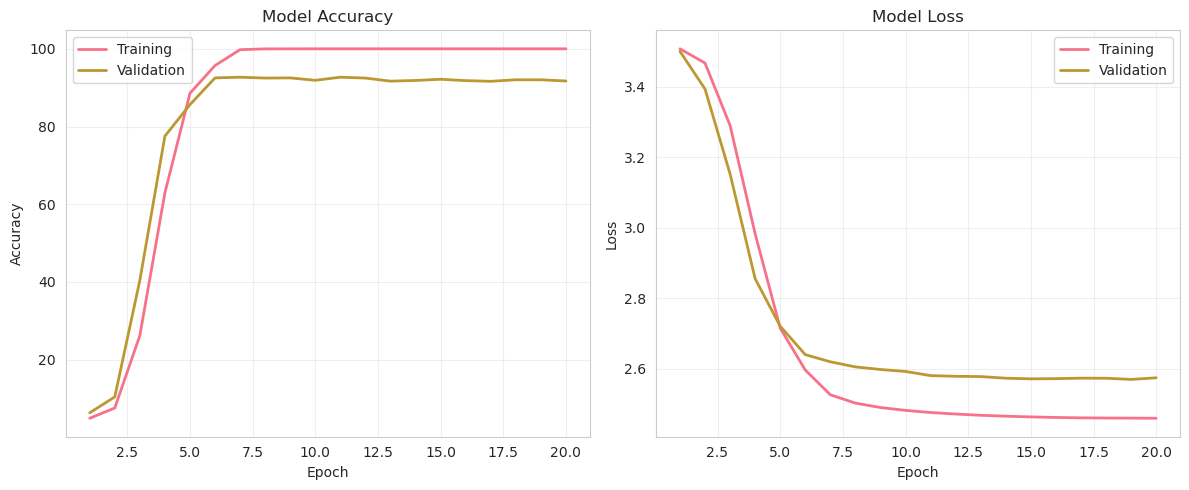

In [27]:
plot_metrics_styled(metrics_df)

## 4. cell type prediction

In [28]:
# Lets now predict all the cells in the anndata object by loading the model we just created.
model = utils.load_model(module_save_filepath)

/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/pollock/utils.py:207: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_fp, map_lo

In [29]:
# note that if you are predicting a large dataset and don't need the pollock umap embeddings you can set make_umap to False to increase runtime speed
adata = utils.predict_adata(model, counts_adata, make_umap=True)
adata

2025-09-09 08:18:13,025 12123 genes overlap with model after filtering
2025-09-09 08:18:13,025 14 genes missing from dataset after filtering
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/pollock/dataloaders.py:104: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata)
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
2025-09-09 08:18:29,012 starting prediction of 44269 cells
/datb/pe/jussi/pollock/env/lib/python3.11/site-packages/pollock/dataloaders.py:144: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a 

AnnData object with n_obs × n_vars = 44269 × 12137
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'celltype', 'cell_type', 'RNA_snn_res.0.8', 'seurat_clusters', 'RNA_snn_res.0.5', 'n_counts', 'size_factors', 'y_pred', 'predicted_cell_type_probability', 'predicted_cell_type', 'probability ATF3+', 'probability Ab-RA-LTMR', 'probability Ab-SA/Field', 'probability Ad-LTMR', 'probability C-LTMR', 'probability Mrgprb4', 'probability NP1', 'probability NP2', 'probability NP3', 'probability PEP1.1.a', 'probability PEP1.1.b', 'probability PEP1.2', 'probability PEP1.3.a', 'probability PEP1.3.b', 'probability PEP1.4', 'probability PEP2.1', 'probability PEP2.2', 'probability PEP3.1', 'probability PEP3.2', 'probability Proprioceptor', 'probability Rxfp1', 'probability TRPM8.1', 'probability TRPM8.2'
    var: 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_emb', 'X_umap', 'prediction_probs'

In [32]:
# After prediction we have several additions to the anndata object
# Predicted cell type and prediction probabilities are now columns in .obs
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,dataset,celltype,cell_type,RNA_snn_res.0.8,seurat_clusters,RNA_snn_res.0.5,n_counts,...,probability PEP1.3.b,probability PEP1.4,probability PEP2.1,probability PEP2.2,probability PEP3.1,probability PEP3.2,probability Proprioceptor,probability Rxfp1,probability TRPM8.1,probability TRPM8.2
10X91_1_AACACGTCAAGTTGTC-1,10X91_1,24534.0,4982,CD1,PEP1.2,PEP1.2,38,7,7,4011.631604,...,0.000035,0.000112,0.000184,0.000004,0.000070,0.000028,0.000006,3.158885e-05,0.000154,0.000002
10X91_1_AACCGCGCAAATACAG-1,10X91_1,14483.0,3973,CD1,C-LTMR,C-LTMR,40,0,0,3802.096398,...,0.002002,0.001065,0.000212,0.001915,0.000098,0.004536,0.000057,2.075105e-04,0.000567,0.002368
10X91_1_AACTCTTGTACACCGC-1,10X91_1,36109.0,5599,CD1,C-LTMR,C-LTMR,40,0,0,4040.732346,...,0.002448,0.001582,0.000448,0.003452,0.000216,0.006153,0.000150,4.461435e-04,0.000745,0.004461
10X91_1_AACTTTCGTAGCGTGA-1,10X91_1,27680.0,5000,CD1,PEP1.4,PEP1.4,47,2,2,3909.126481,...,0.000263,0.939679,0.004677,0.000096,0.000280,0.000175,0.000889,1.034698e-05,0.000797,0.000379
10X91_1_AAGACCTCACGCCAGT-1,10X91_1,29386.0,5206,CD1,PEP1.4,PEP1.4,47,2,2,3977.990176,...,0.000661,0.992592,0.000902,0.000047,0.000244,0.000222,0.000077,5.377664e-07,0.000075,0.000539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6656593_TTTGGTTTCCATTGTT-1,GSM6656593,19445.0,4359,Zhang,PEP1.1.a,PEP1.1.a,3,3,3,3797.528019,...,0.000081,0.000078,0.000116,0.000013,0.000083,0.000004,0.000061,3.863934e-05,0.000064,0.000946
GSM6656593_TTTGGTTTCTATCGCC-1,GSM6656593,16923.0,4076,Zhang,PEP1.1.a,PEP1.1.a,3,3,3,3750.732893,...,0.000087,0.000216,0.000208,0.000031,0.000118,0.000003,0.000117,4.309414e-05,0.000152,0.000969
GSM6656593_TTTGTTGGTCGTAATC-1,GSM6656593,54913.0,5927,Zhang,Ad-LTMR,Ad-LTMR,15,8,8,3810.900738,...,0.000001,0.000093,0.000028,0.000120,0.000214,0.000069,0.000004,6.123586e-05,0.000043,0.000301
GSM6656593_TTTGTTGGTGGACCAA-1,GSM6656593,8368.0,3015,Zhang,PEP1.1.b,PEP1.1.b,3,3,3,3580.850533,...,0.041303,0.000372,0.002941,0.001930,0.009572,0.001667,0.004400,2.068882e-03,0.002068,0.040968


In [33]:
# The pollock cell embeddings, along with their 2-D umap decomposed counterparts are in adata.obsm
adata.obsm['X_emb'].shape, adata.obsm['X_umap'].shape

((44269, 64), (44269, 2))

... storing 'orig.ident' as categorical
... storing 'dataset' as categorical
... storing 'celltype' as categorical
... storing 'cell_type' as categorical
... storing 'predicted_cell_type' as categorical


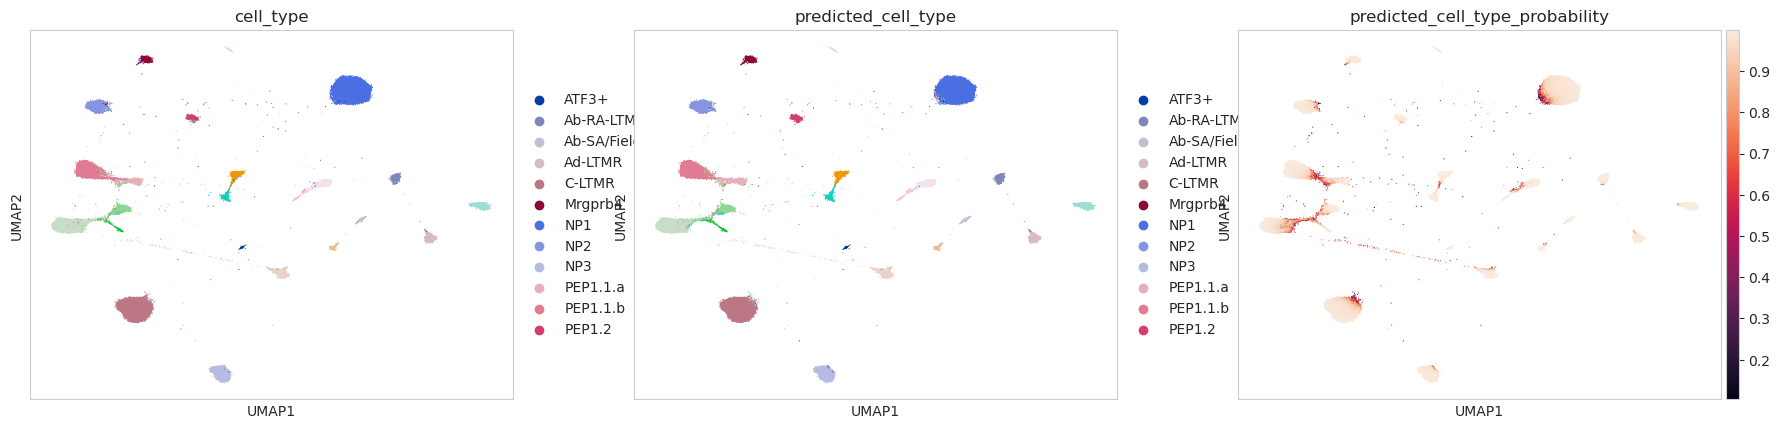

In [34]:
sc.pl.umap(adata, color=['cell_type', 'predicted_cell_type', 'predicted_cell_type_probability'])

## 5. model performance

In [35]:
def get_metrics(y_true_labels, y_pred_labels):
    classes = sorted(set(y_true_labels))

    y_pred = [classes.index(c) for c in y_pred_labels]
    y_true = [classes.index(c) for c in y_true_labels]

    clf_report = classification_report(y_true, y_pred, labels=list(range(len(classes))), target_names=classes,
                             output_dict=True)
    clf_report = pd.DataFrame.from_dict(clf_report)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    cm = pd.DataFrame(data=cm, index=classes, columns=classes)
    
    clf_report.index.name = 'metric'
    cm.index.name = 'cell_type'
    
    return clf_report, cm

In [36]:
# using only validation anndata to look at performance metrics
val_adata = adata[val_ids]
y_pred = val_adata.obs['predicted_cell_type'].to_list()
y_true = val_adata.obs['cell_type'].to_list()
clf_report, cm = get_metrics(y_true, y_pred)

<Axes: ylabel='cell_type'>

Text(0.5, 23.52222222222222, 'predicted')

Text(50.72222222222221, 0.5, 'manual annotation')

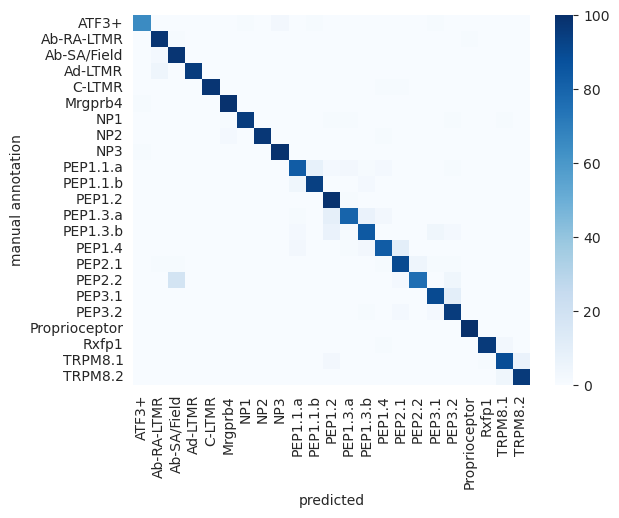

In [37]:
# With the confusion matrix we can visualize how cells are being classified
sns.heatmap(cm, cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('manual annotation')

<Axes: ylabel='cell_type'>

Text(0.5, 23.52222222222222, 'predicted')

Text(50.72222222222221, 0.5, 'manual annotation')

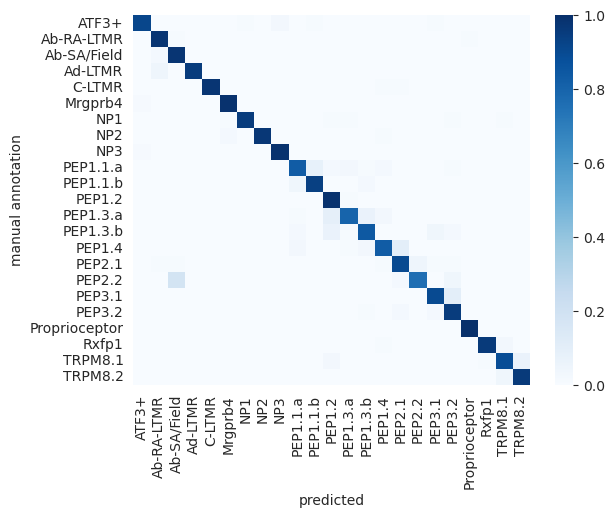

In [38]:
# Normalized to number of cells
sns.heatmap(cm / cm.sum(axis=1), cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('manual annotation')

In [39]:
# We can also look at the precision, recall, and f1-score for all cell types
clf_report

,ATF3+,Ab-RA-LTMR,Ab-SA/Field,Ad-LTMR,C-LTMR,Mrgprb4,NP1,NP2,NP3,PEP1.1.a,...,PEP2.2,PEP3.1,PEP3.2,Proprioceptor,Rxfp1,TRPM8.1,TRPM8.2,accuracy,macro avg,weighted avg
metric,,,,,,,,,,,,,,,,,,,,,
precision,0.970149,0.924528,0.830508,1.000000,1.000000,0.970588,0.989583,1.000000,0.970588,0.892473,...,0.938272,0.918367,0.833333,0.990099,0.989691,0.917526,0.932039,0.924262,0.927589,0.927046
recall,0.915493,0.980000,0.980000,0.950000,0.980000,0.990000,0.950000,0.970000,0.990000,0.830000,...,0.760000,0.900000,0.950000,1.000000,0.960000,0.890000,0.960000,0.924262,0.924152,0.924262
f1-score,0.942029,0.951456,0.899083,0.974359,0.989899,0.980198,0.969388,0.984772,0.980198,0.860104,...,0.839779,0.909091,0.887850,0.995025,0.974619,0.903553,0.945813,0.924262,0.924173,0.923945
support,71.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.924262,2271.000000,2271.000000


In [41]:
# save clf_report
clf_report.to_csv('clf_report_full_atlas.csv')